In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

Extent       Date
0    1090625.815 1979-01-01
1    1157634.866 1979-02-01
2    1299583.477 1979-03-01
3    1137194.680 1979-04-01
4     983083.453 1979-05-01
..           ...        ...
533   781460.891 2023-06-01
534   331845.048 2023-07-01
535    99334.625 2023-08-01
536    49359.723 2023-09-01
537    85693.282 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 22s 272ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756 - val_loss: 0.1587 - val_root_mean_squared_error: 0.3983
Epoch 2/50
53/53 [==============================] - 13s 248ms/step - loss: 0.1020 - root_mean_squared_error: 0.3193 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2149
Epoch 3/50
53/53 [==============================] - 11s 221ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 4/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0387 - root_mean_squared_error: 0.1966 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706
Epoch 5/50
53/53 [==============================] - 15s 279ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 6/50
53/53 [==============================] - 15s 290ms/step - loss: 0.0273 - root_mean_squared_error: 0.1653 - val_loss: 0.0201 

53/53 [==============================] - 12s 226ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 30/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 31/50
53/53 [==============================] - 12s 228ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 32/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 33/50
53/53 [==============================] - 12s 234ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 34/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0039 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.24643030166626 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

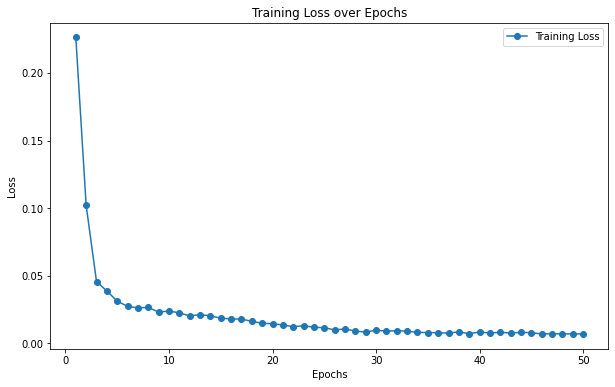

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

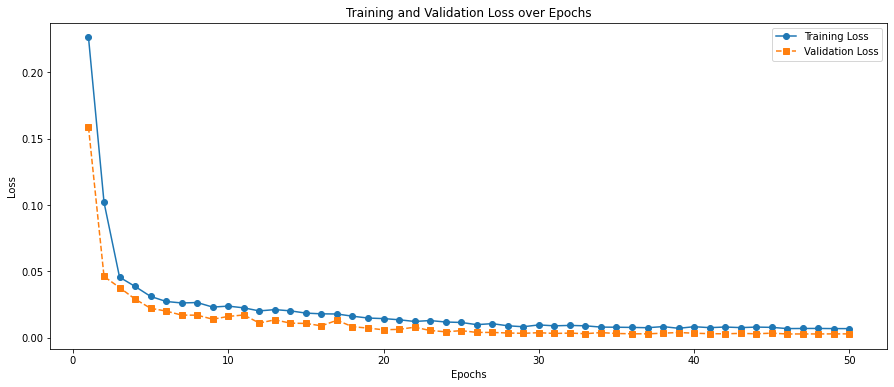

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0631075879835378
MAE : 0.0468876446028045


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        1.103727e+05      46930.952
1        4.236891e+04      27600.624
2        2.416999e+05      61057.940
3        5.602649e+05     291275.949
4        8.795392e+05     678576.504
5        1.116278e+06     974461.347
6        1.237564e+06    1181121.087
7        1.210228e+06    1236299.254
8        1.100238e+06    1036981.003
9        9.207439e+05     847489.150
10       6.645226e+05     619129.338
11       3.324097e+05     195688.491
12       5.700378e+04      36670.811
13      -4.344508e+04      31777.310
14       9.252967e+04      82762.022
15       3.444878e+05     400043.823
16       6.588067e+05     733089.555
17       9.387341e+05     917362.266
18       1.104042e+06    1040584.040
19       1.137481e+06    1147997.675
20       1.046762e+06    1074255.327
21       8.821811e+05     875527.315
22       6.299346e+05     629820.756
23       3.092744e+05     204308.900
24       5.168078e+04      45059.062
25      -3.928887e+04      33770.277
26       9.740480e+04      64135.631
27       3.526787e+05     400581.715
28       6.737499e+05     698631.451
29       9.476298e+05     973313.225
30       1.104589e+06    1335339.087
31       1.123795e+06    1429096.704
32       1.034805e+06    1206542.314
33       8.738851e+05    1079292.433
34       6.358619e+05     788101.638
35       3.159898e+05     397326.270
36       4.686549e+04      97802.348
37      -4.349663e+04      62212.219
38       1.033861e+05     154051.600
39       3.788096e+05     610663.893
40       7.316639e+05     756679.164
41       1.044447e+06     962270.215
42       1.240551e+06    1235154.518
43       1.275219e+06    1161744.519
44       1.198297e+06    1136918.669
45       1.044363e+06     995852.026
46       7.960865e+05     781460.891
47       4.429362e+05     331845.048
48       1.337314e+05      99334.625
49       2.804926e+04      49359.723
50       1.856613e+05      85693.282

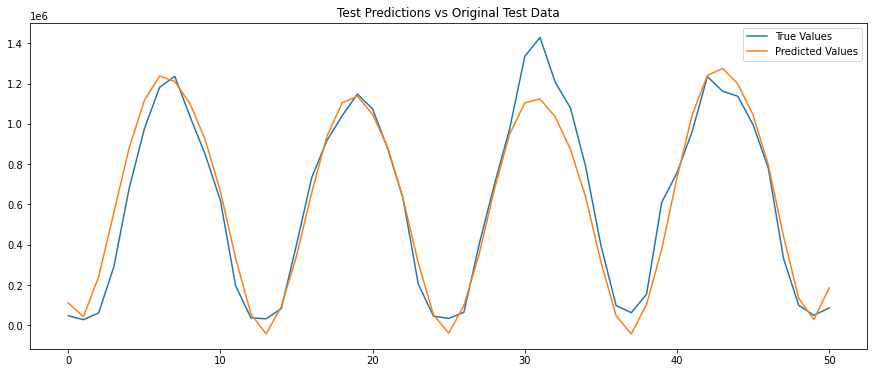

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

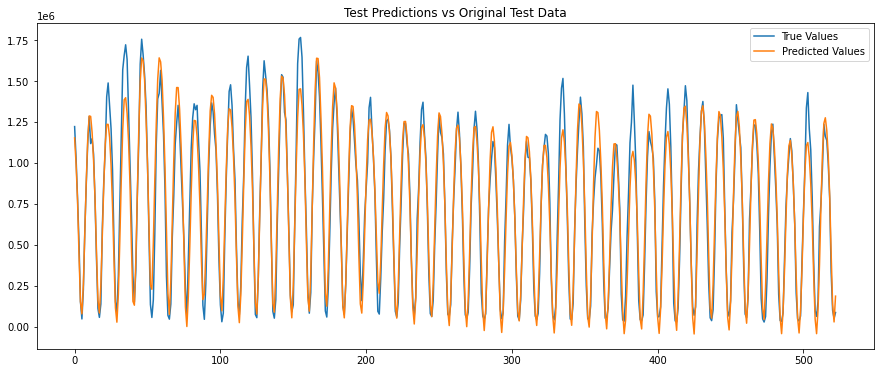

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()